In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
livetime = 8 * u.h
n_obs = 125
l = 0.5
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 40), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 200), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=l * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [8]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s



In [9]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [10]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 3498 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [11]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 5743 
    Total predicted counts          : 5664.81
    Total off counts                : 17684.00

    Total background counts         : 3536.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 35.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [12]:
%%time

datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 479 ms, sys: 8.07 ms, total: 487 ms
Wall time: 487 ms


Text(0, 0.5, 'No. of observations')

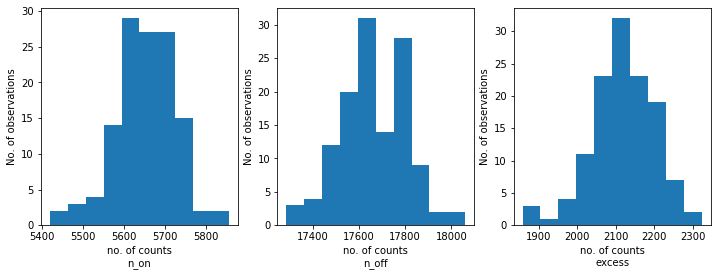

In [13]:
n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:
dataset_stacked = Datasets(datasets).stack_reduce()

In [15]:
%%time

e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV

dataset_stacked.model = model
print(dataset_stacked.livetime)

stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

1000.0 h
CPU times: user 166 ms, sys: 0 ns, total: 166 ms
Wall time: 427 ms


In [16]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 60
	total stat : 32.33



In [17]:
fpes = FluxPointsEstimator(datasets=[dataset_stacked], e_edges=e_edges)
flu_points = fpes.run()
print(flu_points.table_formatted)

e_ref  e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
 TeV    TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
------ ------ ------- ... --------------- --------------- ---------------
 0.048  0.032   0.072 ...       9.810e-12       9.775e-12       9.842e-12
 0.121  0.072   0.203 ...       6.497e-13       6.496e-13       6.498e-13
 0.307  0.203   0.464 ...       8.524e-14       8.533e-14       8.515e-14
 0.702  0.464   1.061 ...       1.381e-14       1.383e-14       1.379e-14
 1.778  1.061   2.981 ...       1.329e-15       1.333e-15       1.326e-15
 4.507  2.981   6.813 ...       1.144e-16       1.148e-16       1.141e-16
10.300  6.813  15.571 ...       8.503e-18       8.648e-18       8.361e-18
26.102 15.571  43.755 ...       3.117e-20       3.281e-20       2.935e-20
66.147 43.755 100.000 ...       1.562e-30       5.801e-28       1.015e-36


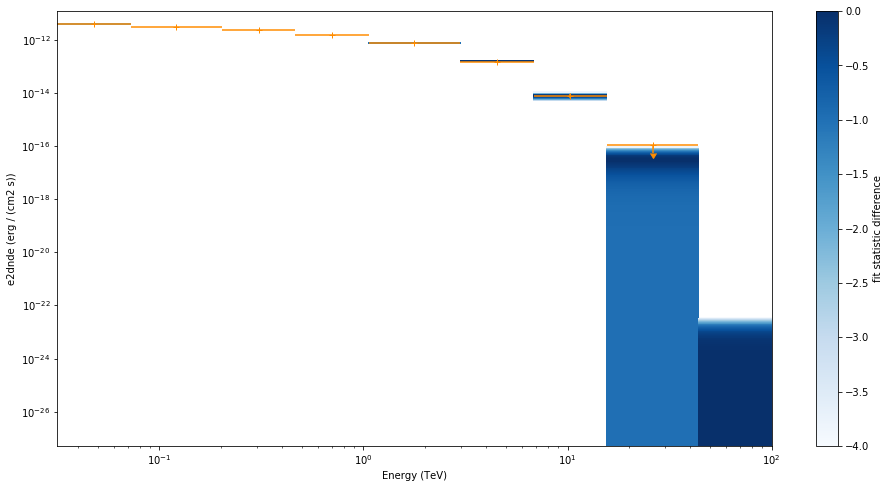

In [18]:
plt.figure(figsize=(16, 8))
flu_points.table["is_ul"] = flu_points.table["ts"] < 4
ax = flu_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flu_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)

In [19]:
flu_points_dataset = FluxPointsDataset(
    data=flu_points, models=model_best_stacked
)

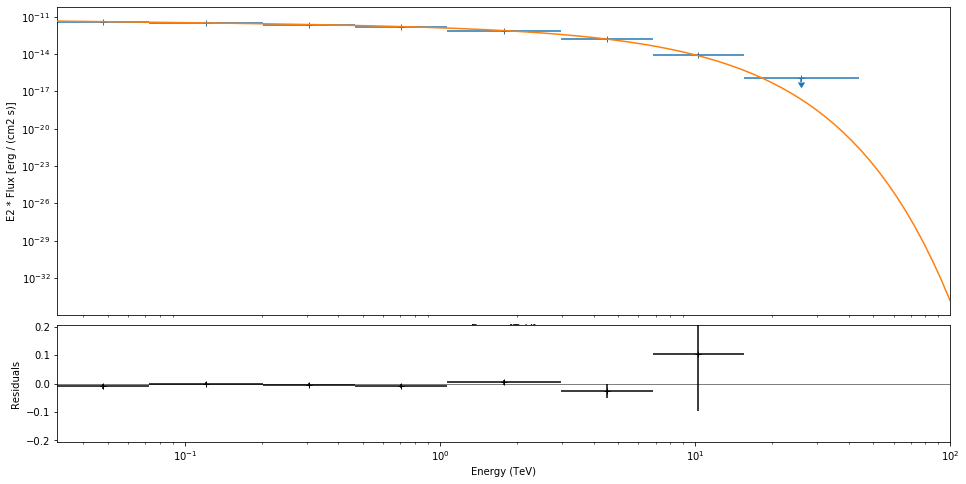

In [20]:
plt.figure(figsize=(16, 8))
flu_points_dataset.peek();

In [21]:
simuu = ExpCutoffPowerLawSpectralModel(
    index=result_stacked.parameters["index"].value,
    amplitude=result_stacked.parameters["amplitude"].value * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=result_stacked.parameters["lambda_"].value * u.Unit("TeV-1"),
    alpha = 1,
)

print(simuu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.221e+00   nan                nan nan  False
amplitude 1.282e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.978e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


<function matplotlib.pyplot.show(*args, **kw)>

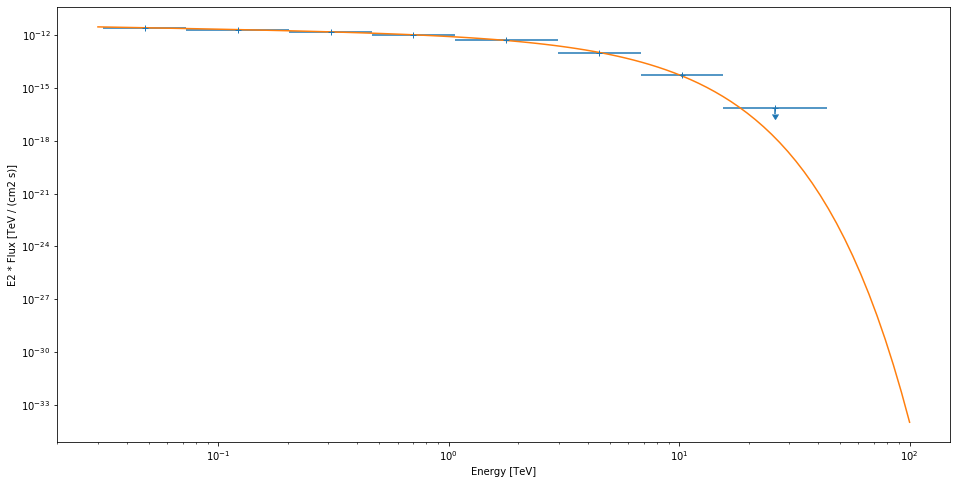

In [22]:
energy_range = [0.03, 100] * u.TeV
plt.figure(figsize=[16,8])
flu_points.plot(energy_power=2)
simuu.plot(energy_range=energy_range, energy_power=2)
plt.show

In [23]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [24]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

Text(0, 0.5, 'E2 * Flux [Tev / (cm2 s)]')

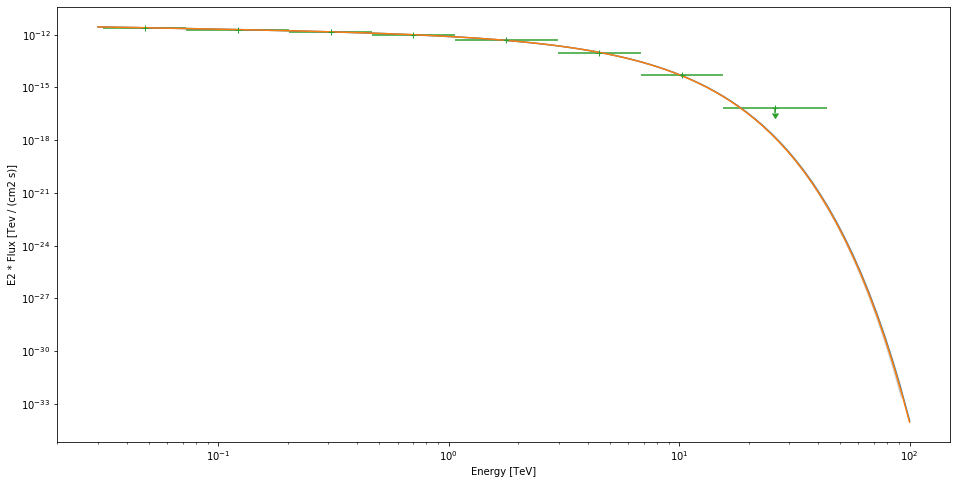

In [25]:
plt.figure(figsize=[16,8])
simuu.plot(energy_range=energy_range, energy_power=2)
model_simu.plot(energy_range=energy_range, energy_power=2)
flu_points.plot(energy_power=2)
plot_error(self=simuu, covar=result_stacked.parameters.covariance, energy_range=energy_range, energy_power=2)
plt.xlabel('Energy [TeV]')
plt.ylabel('E2 * Flux [Tev / (cm2 s)]')

In [26]:
dataset_stacked.stat_array()

array([9.06321261e-01, 2.55921599e-01, 3.18213623e+00, 3.10441321e-02,
       1.17872474e+00, 2.35660002e-04, 1.19694187e-01, 7.52467546e-02,
       1.47472257e-02, 5.12587291e-02, 4.55126851e-01, 8.49205173e-01,
       1.11208191e-01, 1.38906498e-02, 5.55839720e-01, 1.21865939e-01,
       2.39869336e+00, 1.96808839e-02, 3.00152899e-02, 1.03470702e+00,
       4.78633401e+00, 5.97154348e-01, 3.06271774e+00, 6.63986139e-01,
       2.86882319e-01, 1.49461092e-01, 2.91822062e-01, 2.41077415e+00,
       3.63833731e-01, 3.93787339e-01, 1.52645145e-01, 7.76029449e+00,
       7.30917588e-06, 4.48337575e-04, 9.24512964e-06, 9.64565743e-07,
       1.49641397e-09, 2.51806394e-12, 3.02377192e-15])

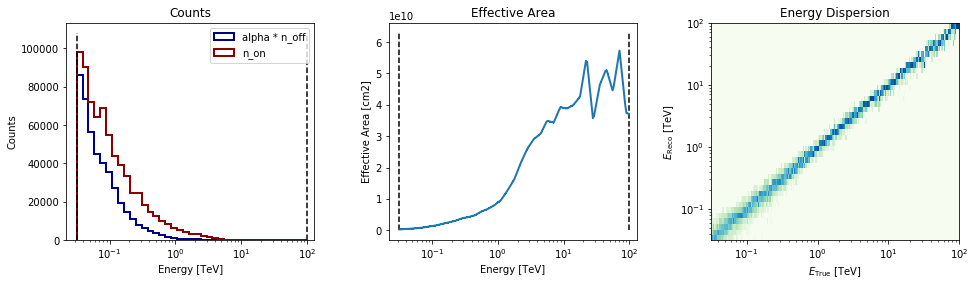

In [27]:
dataset_stacked.peek()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8cf916b160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8cf92b44a8>)

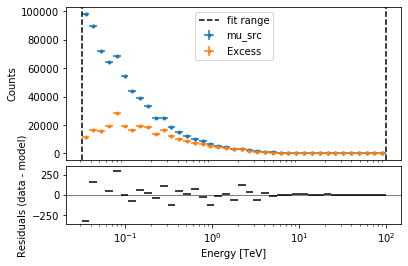

In [28]:
dataset_stacked.plot_fit()

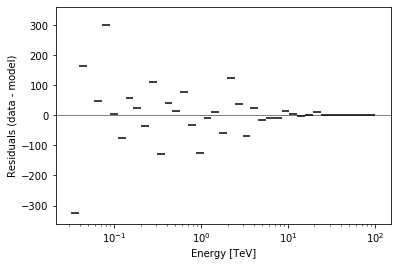

In [29]:
dataset_stacked.plot_residuals()

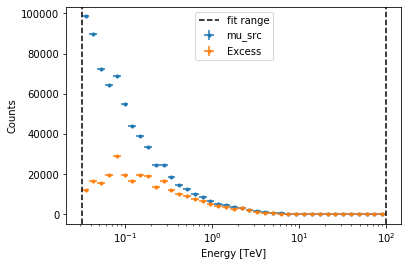

In [30]:
dataset_stacked.plot_counts()

In [31]:
dataset_stacked.stat_sum()

32.32572199802967

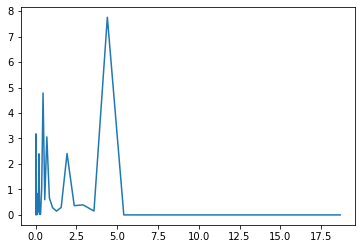

In [32]:
plt.plot(energy_axis.bin_width, dataset_stacked.stat_array())

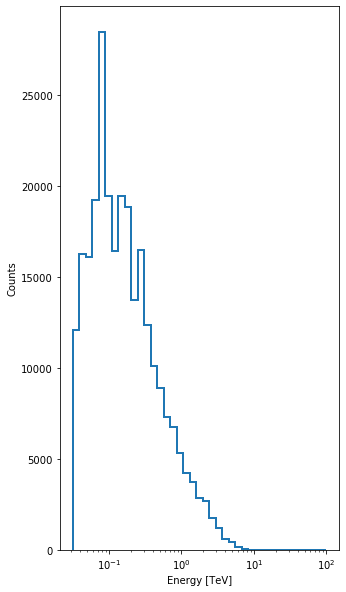

In [33]:
dataset_stacked.npred_sig().peek()

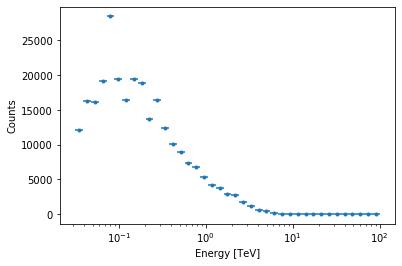

In [34]:
dataset_stacked.npred_sig().plot()

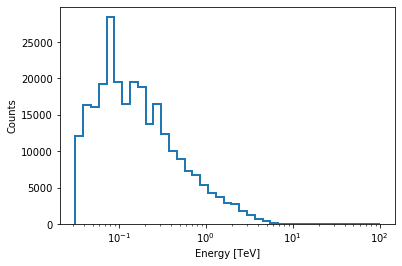

In [35]:
dataset_stacked.npred_sig().plot_hist()

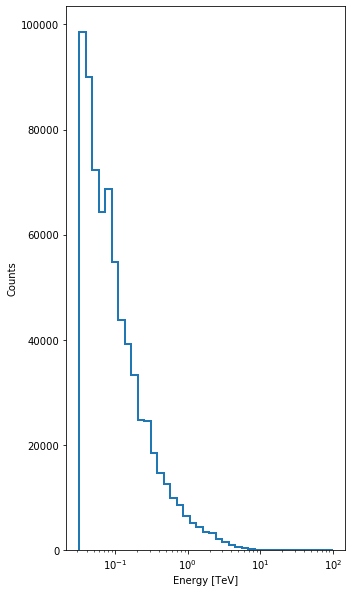

In [36]:
dataset_stacked.npred().peek()

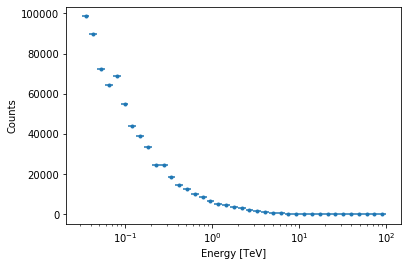

In [37]:
dataset_stacked.npred().plot()

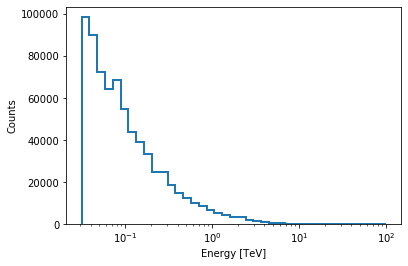

In [38]:
dataset_stacked.npred().plot_hist()